In [1]:
#!/usr/bin/env python
# xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx #
# xxxxxxxxxxxxxxxxxxx--------------------COMPUTE POSITION ANGLE OF THE MOON----------------------xxxxxxxxxxxxxxxxxxxx #
# xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx #

# ------------------------------------------------------------------------------------------------------------------- #
# Import Required Libraries
# ------------------------------------------------------------------------------------------------------------------- #
import numpy as np
import pandas as pd
from astropy import units as u
from astropy.coordinates import Distance
from astropy.time import Time, TimeDelta
from astropy.coordinates import get_body, Longitude, Latitude, EarthLocation, AltAz

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.ticker import MultipleLocator
from matplotlib.dates import DateFormatter, MinuteLocator, HourLocator
plt.style.use('ggplot')
# ------------------------------------------------------------------------------------------------------------------- #


# ------------------------------------------------------------------------------------------------------------------- #
# Global Variables [Location = Bengaluru]
# ------------------------------------------------------------------------------------------------------------------- #
sun_radius = 6.957e10 * u.cm
moon_radius = 1.737e8 * u.cm

DATE = '2020-06-21'
LAT = 12.9352
LON = 77.6245
TIMEZONE = +5.5

lon = Longitude('{0} deg'.format(LON))
lat = Latitude('{0} deg'.format(LAT))
loc = EarthLocation.from_geodetic(lon, lat)

File_EXIF = 'AnnularSolarEclipse_June21.csv'
data_exif = pd.read_csv(File_EXIF, comment='#')

time_arr = data_exif['Time'].values
timearr_local = [Time("{0} {1}".format(DATE, time), format='iso') for time in time_arr]
timearr_utc = [timelocal - TIMEZONE * u.hour for timelocal in timearr_local]
# ------------------------------------------------------------------------------------------------------------------- #


# ------------------------------------------------------------------------------------------------------------------- #
# Computing the Position Angle of Moon wrt Sun [For EXIF File]
# ------------------------------------------------------------------------------------------------------------------- #
for index, time in enumerate(timearr_utc):
    sun = get_body('sun', time, loc, ephemeris='builtin')
    moon = get_body('moon', time, loc, ephemeris='builtin')
    pa = sun.position_angle(moon).degree
    altaz_sun = sun.transform_to(AltAz(location=loc, obstime=time))
    altaz_moon = moon.transform_to(AltAz(location=loc, obstime=time))
    
    data_exif.loc[index, 'UT'] = time
    data_exif.loc[index, 'PA'] = round(sun.position_angle(moon).degree, 3)
    data_exif.loc[index, 'SunALT'] = round(altaz_sun.alt.degree, 3)
    data_exif.loc[index, 'SunAZ'] = round(altaz_sun.az.degree, 3)
    data_exif.loc[index, 'MoonALT'] = round(altaz_moon.alt.degree, 3)
    data_exif.loc[index, 'MoonAZ'] = round(altaz_moon.az.degree, 3)

data_exif.to_csv('AnnularSolarEclipsePA_Jun21.csv')
# ------------------------------------------------------------------------------------------------------------------- #

In [2]:
# ------------------------------------------------------------------------------------------------------------------- #
# Generate the Position Angle of Moon wrt Sun in Continuous Steps of 1 Minute
# ------------------------------------------------------------------------------------------------------------------- #
start_time = '09:50:00'
end_time = '13:50:00'

timestart_local = Time("{0} {1}".format(DATE, start_time), format='iso')
timeend_local = Time("{0} {1}".format(DATE, end_time), format='iso')
timestart_utc = timestart_local - TIMEZONE * u.hour
timeend_utc = timeend_local - TIMEZONE * u.hour

data = pd.DataFrame()

index = 0
time = timestart_utc
while time <= timeend_utc:
    sun = get_body('sun', time, loc, ephemeris='builtin')
    moon = get_body('moon', time, loc, ephemeris='builtin')
    pa = sun.position_angle(moon).degree
    altaz_sun = sun.transform_to(AltAz(location=loc, obstime=time))
    altaz_moon = moon.transform_to(AltAz(location=loc, obstime=time))
    sun_dist = Distance(sun.distance, unit=u.cm)
    moon_dist = Distance(moon.distance, unit=u.cm)
    sun_size = 2 * sun_radius * 60 * 180 / (np.pi * sun_dist)
    moon_size = 2 * moon_radius * 60 * 180 / (np.pi * moon_dist)

    data.loc[index, 'UT'] = time
    data.loc[index, 'PA'] = round(sun.position_angle(moon).degree, 3)
    data.loc[index, 'SunALT'] = round(altaz_sun.alt.degree, 3)
    data.loc[index, 'SunAZ'] = round(altaz_sun.az.degree, 3)
    data.loc[index, 'SunAZ'] = round(altaz_sun.az.degree, 3)
    data.loc[index, 'SunSize'] = round(float(sun_size), 3)
    data.loc[index, 'MoonALT'] = round(altaz_moon.alt.degree, 3)
    data.loc[index, 'MoonAZ'] = round(altaz_moon.az.degree, 3)
    data.loc[index, 'MoonSize'] = round(float(moon_size), 3)

    index += 1
    time += TimeDelta(60 * u.s)
    
# ------------------------------------------------------------------------------------------------------------------- #

/home/avinash/Softwares/miniconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


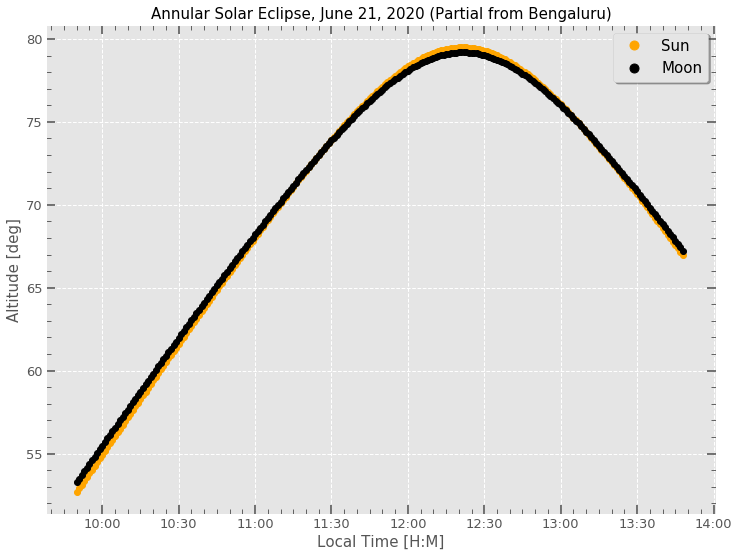

In [3]:
# ------------------------------------------------------------------------------------------------------------------- #
# Animating the Partial Eclipse in Bengaluru
# ------------------------------------------------------------------------------------------------------------------- #
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111)

time = [(time + TIMEZONE * u.hour).utc.datetime for time in data['UT'].values]
sunalt = data['SunALT'].values
sunsize = data['SunSize'].values
moonalt = data['MoonALT'].values
moonsize = data['MoonSize'].values

points = [ax.plot(time, obj, c=['orange', 'k'][idx], marker='o', ls='', label=['Sun', 'Moon'][idx], zorder=idx + 1)[0] 
          for idx, obj in enumerate([sunalt, moonalt])]

def initialize():
    global time, sunalt, moonalt, sunsize, moonsize
    points[0].set_data(time[0], sunalt[0])
    points[1].set_data(time[0], moonalt[0])
#     sun = plt.Circle((time[0], sunalt[0]), sunsize[0])
#     moon = plt.Circle((time[0], moonalt[0]), moonsize[0])
#     ax.add_artist(sun)
#     ax.add_artist(moon)
    
    return points

def animate(i):
    global time, sunalt, moonalt, sunsize, moonsize
    points[0].set_data(time[:i], sunalt[:i])
    points[1].set_data(time[:i], moonalt[:i])
#     sun = plt.Circle((time[:i], sunalt[:i]), sunsize[:i])
#     moon = plt.Circle((time[:i], moonalt[:i]), moonsize[:i])
#     ax.add_artist(sun)
#     ax.add_artist(moon)
    
    return points

ax.legend(fontsize=15, markerscale=1.5, fancybox=True, shadow=True)
ax.grid('True', ls='--', lw=1)
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')
ax.yaxis.set_major_locator(MultipleLocator(5))
ax.yaxis.set_minor_locator(MultipleLocator(1))
ax.xaxis.set_major_locator(MinuteLocator(byminute=range(0, 60, 30)))
ax.xaxis.set_minor_locator(MinuteLocator(byminute=range(0, 60, 5)))
ax.xaxis.set_major_formatter(DateFormatter('%H:%M'))
ax.tick_params(axis='both', which='major', direction='in', width=1.6, length=9, labelsize=13)
ax.tick_params(axis='both', which='minor', direction='in', width=0.9, length=5, labelsize=13)

ax.set_ylabel('Altitude [deg]', fontsize=15)
ax.set_xlabel('Local Time [H:M]', fontsize=15)
ax.set_title('Annular Solar Eclipse, June 21, 2020 (Partial from Bengaluru)', fontsize=15)

anim = animation.FuncAnimation(fig, animate, init_func=initialize, frames=len(time), interval=50, blit=True, repeat=False)
anim.save('AnnularSolarEclipseJune21_Bengaluru.gif', writer='imagemagick')
plt.show()
# ------------------------------------------------------------------------------------------------------------------- #

In [6]:
# ------------------------------------------------------------------------------------------------------------------- #
# Save The Eclipse Data in a Data File
# ------------------------------------------------------------------------------------------------------------------- #
data.to_csv('SolarEclipseJune21_Bengaluru.dat', sep='\t')

In [4]:
# import matplotlib.pyplot as plt
# import matplotlib.animation as animation
# from matplotlib.dates import DateFormatter, MinuteLocator, HourLocator
# from matplotlib.ticker import MultipleLocator
# plt.style.use('ggplot')

# fig = plt.figure(figsize=(12, 9))
# ax = fig.add_subplot(111)

# time = [(time + TIMEZONE * u.hour).utc.datetime for time in data['UT'].values]
# sunalt = data['SunALT'].values
# moonalt = data['MoonALT'].values
# sunsize = [5 * x for x in data['SunSize'].values]
# moonsize = [5 * x for x in data['MoonSize'].values]

# points = [ax.plot(time, obj, c=['orange', 'k'][idx], marker='o', ls='', label=['Sun', 'Moon'][idx])[0] for idx, obj in enumerate([sunalt, moonalt])]
# lines = [ax.plot(time, obj, c=['orange', 'k'][idx], marker='', ls='-', label=None)[0] for idx, obj in enumerate([sunalt, moonalt])]
# circles = [ax.add_artist(plt.Circle((time, sunalt), sunsize)),
#            ax.add_artist(plt.Circle((time, moonalt), moonsize))]

# def initialize():
#     global time, sunalt, moonalt, sunsize, moonsize
#     points[0].set_data(time[0], sunalt[0])
#     points[1].set_data(time[0], moonalt[0])
# #     lines[0].set_data(time[0], sunsize[0])
# #     lines[1].set_data(time[0], moonsize[0])

# #     points[0].set_sizes(sunsize / 60)
# #     points[1].set_sizes(moonsize / 60)

#     sun = plt.Circle((time[0], sunalt[0]), sunsize[0])
#     moon = plt.Circle((time[0], moonalt[0]), moonsize[0])
#     ax.add_artist(sun)
#     ax.add_artist(moon)
    
#     return plots, lines

# def animate(i):
#     global time, sunalt, moonalt, sunsize, moonsize
#     points[0].set_data(time[:i], sunalt[:i])
#     points[1].set_data(time[:i], moonalt[:i])
# #     lines[0].set_data(time[:i], sunsize[:i])
# #     lines[1].set_data(time[:i], moonsize[:i])

# #     points[0].set_sizes(sunsize / 60)
# #     points[1].set_sizes(moonsize / 60)
#     sun = plt.Circle((time[:i], sunalt[:i]), sunsize[:i])
#     moon = plt.Circle((time[:i], moonalt[:i]), moonsize[:i])
#     ax.add_artist(sun)
#     ax.add_artist(moon)
    
#     return plots, lines


# ax.legend(fontsize=13, markerscale=1.3, fancybox=True, shadow=True)
# ax.grid('True', ls='--', lw=1)
# ax.xaxis.set_ticks_position('both')
# ax.yaxis.set_ticks_position('both')
# # ax.yaxis.set_major_locator(MultipleLocator(5))
# # ax.yaxis.set_minor_locator(MultipleLocator(1))
# # ax.xaxis.set_major_locator(MinuteLocator(byminute=range(0, 60, 30)))
# # ax.xaxis.set_minor_locator(MinuteLocator(byminute=range(0, 60, 5)))
# # ax.xaxis.set_major_formatter(DateFormatter('%H:%M'))
# ax.tick_params(axis='both', which='major', direction='in', width=1.6, length=9, labelsize=13)
# ax.tick_params(axis='both', which='minor', direction='in', width=0.9, length=5, labelsize=13)

# ax.set_ylabel('Altitude [deg]', fontsize=15)
# ax.set_xlabel('Local Time [H:M]', fontsize=15)
# ax.set_title('Annular Solar Eclipse, June 21, 2020 (Partial from Bengaluru)', fontsize=15)

# anim = animation.FuncAnimation(fig, animate, init_func=initialize, frames=len(time), interval=50, blit=True, repeat=False)
# # anim.save('AnnularSolarEclipseJune21_BengaluruV2.gif', writer='imagemagick')
# plt.show()

AttributeError: 'AxesSubplot' object has no attribute 'set_theta_zero_location'

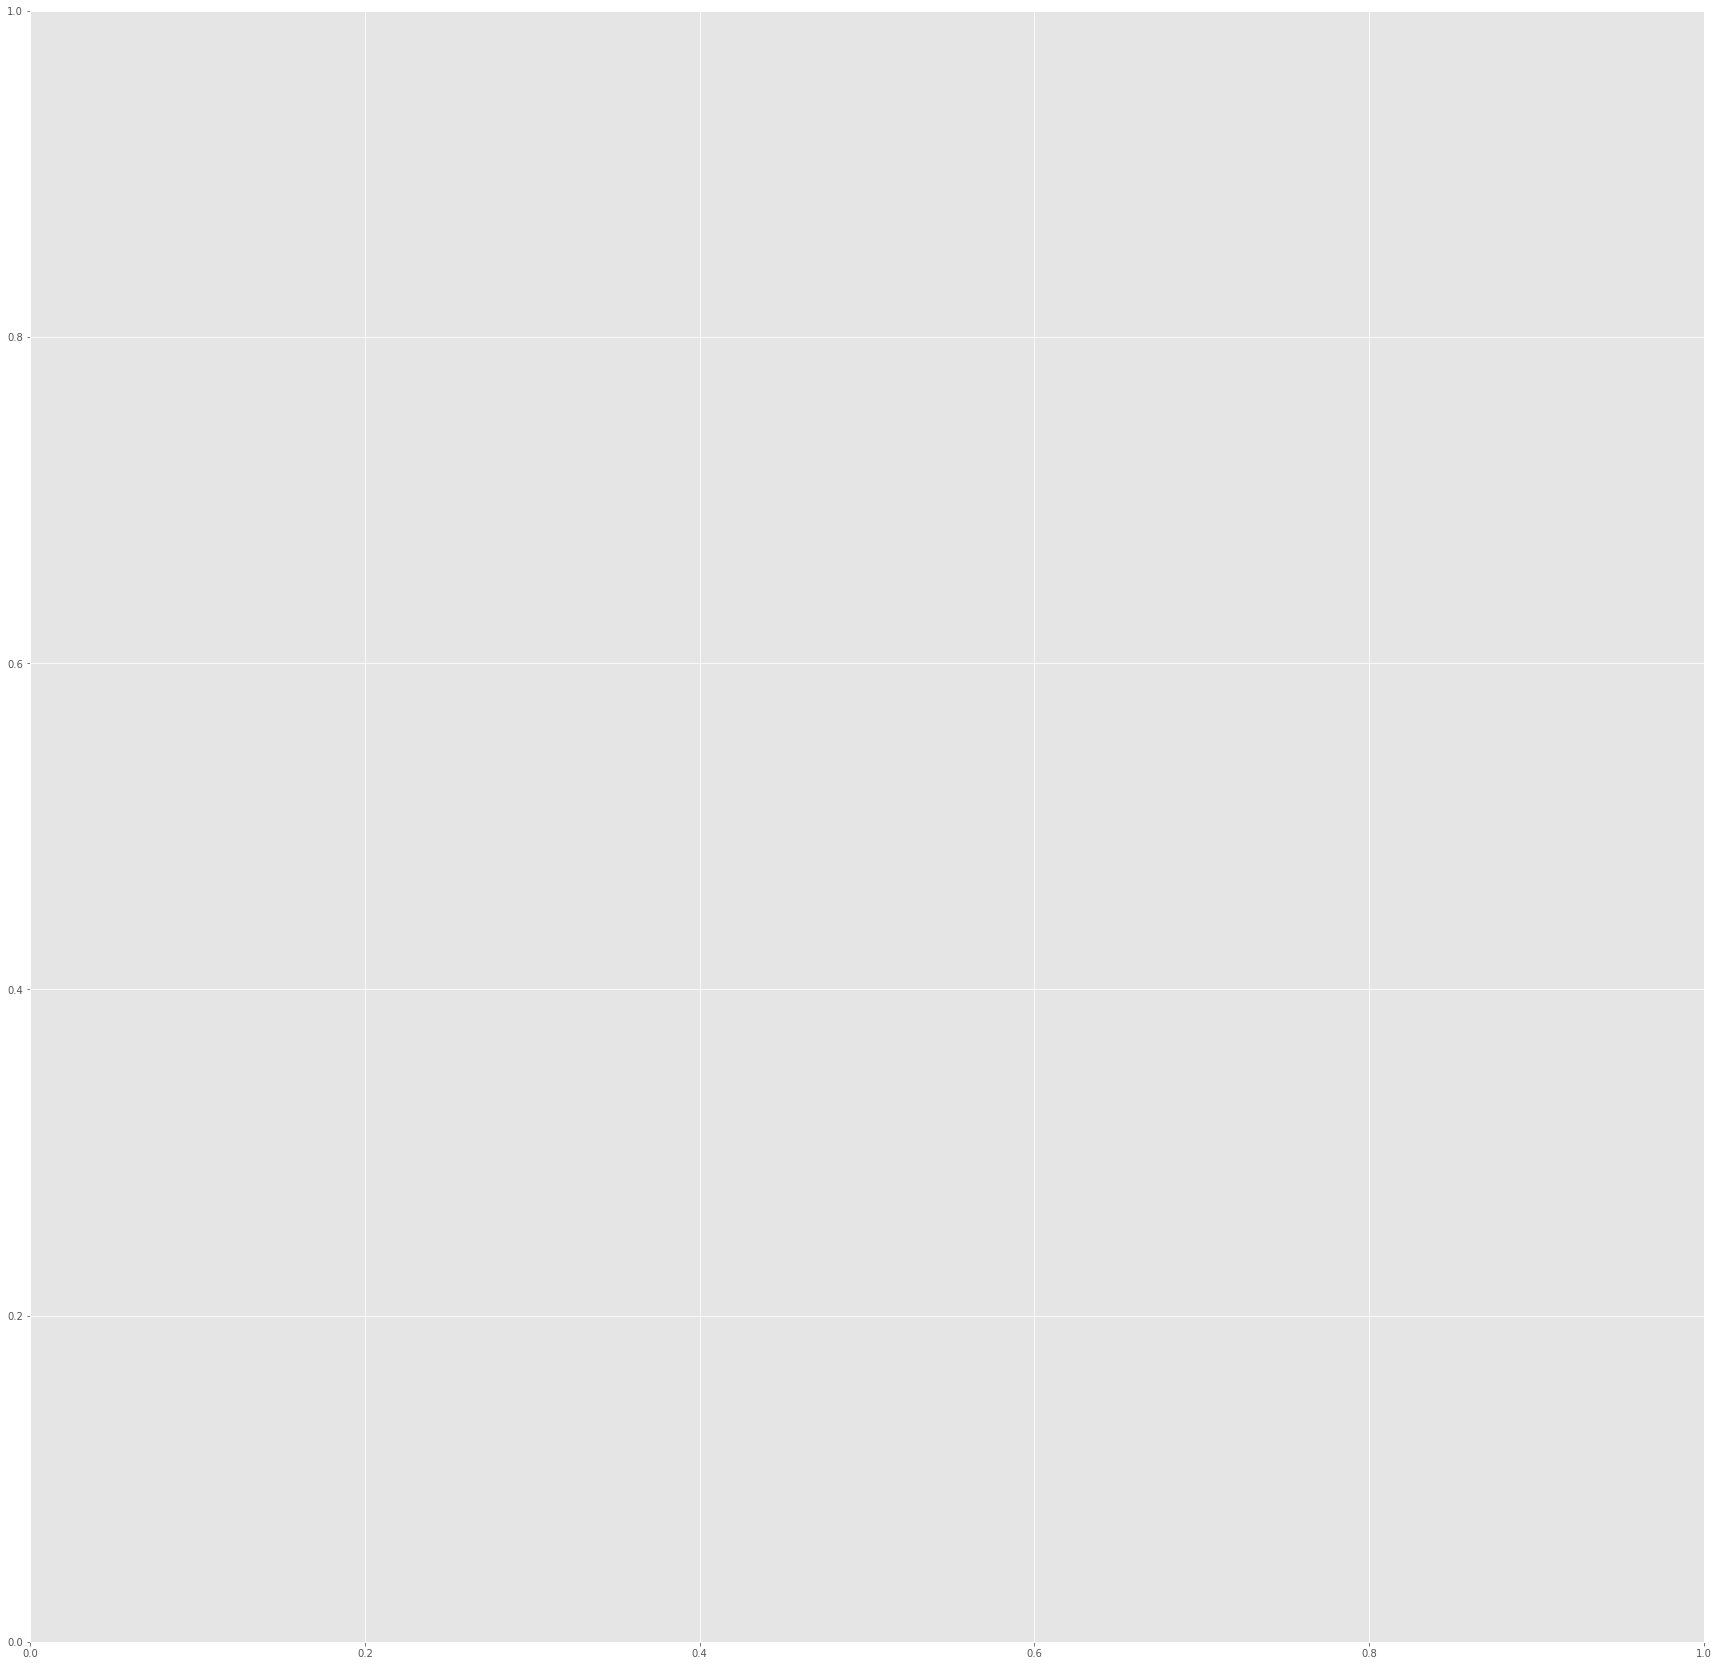

In [5]:
from astroplan.plots import plot_sky
from astroplan import Observer
obs = Observer(location=loc)

fig2, ax2 = plt.subplots(1, 1, figsize=(30, 30))
plot_sky(sun, obs, timearr_utc, ax=ax2)
plot_sky(moon, obs, timearr_utc, ax=ax2)

In [ ]:
"""
===============
Rain simulation
===============

Simulates rain drops on a surface by animating the scale and opacity
of 50 scatter points.

Author: Nicolas P. Rougier
"""
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation


# Create new Figure and an Axes which fills it.
fig = plt.figure(figsize=(7, 7))
ax = fig.add_axes([0, 0, 1, 1], frameon=False)
ax.set_xlim(0, 1), ax.set_xticks([])
ax.set_ylim(0, 1), ax.set_yticks([])

# Create rain data
n_drops = 50
rain_drops = np.zeros(n_drops, dtype=[('position', float, 2),
                                      ('size',     float, 1),
                                      ('growth',   float, 1),
                                      ('color',    float, 4)])

# Initialize the raindrops in random positions and with
# random growth rates.
rain_drops['position'] = np.random.uniform(0, 1, (n_drops, 2))
rain_drops['growth'] = np.random.uniform(50, 200, n_drops)

# Construct the scatter which we will update during animation
# as the raindrops develop.
scat = ax.scatter(rain_drops['position'][:, 0], rain_drops['position'][:, 1],
                  s=rain_drops['size'], lw=0.5, edgecolors=rain_drops['color'],
                  facecolors='none')


def update(frame_number):
    # Get an index which we can use to re-spawn the oldest raindrop.
    current_index = frame_number % n_drops

    # Make all colors more transparent as time progresses.
    rain_drops['color'][:, 3] -= 1.0/len(rain_drops)
    rain_drops['color'][:, 3] = np.clip(rain_drops['color'][:, 3], 0, 1)

    # Make all circles bigger.
    rain_drops['size'] += rain_drops['growth']

    # Pick a new position for oldest rain drop, resetting its size,
    # color and growth factor.
    rain_drops['position'][current_index] = np.random.uniform(0, 1, 2)
    rain_drops['size'][current_index] = 5
    rain_drops['color'][current_index] = (0, 0, 0, 1)
    rain_drops['growth'][current_index] = np.random.uniform(50, 200)

    # Update the scatter collection, with the new colors, sizes and positions.
    scat.set_edgecolors(rain_drops['color'])
    scat.set_sizes(rain_drops['size'])
    scat.set_offsets(rain_drops['position'])


# Construct the animation, using the update function as the animation
# director.
animation = FuncAnimation(fig, update, interval=10)
animation.save('Rain.gif', writer='imagemagick')
plt.show()